#### The reason behind variables selection is based on 
+ 1.Stability 2. Ability to pay 3. Willing to pay
#### Flow  
+ Part 1 :application_train /application_test 
+ Part 2 :bureau/bureau_balance
+ Part 3 :Previous application
+ Part 4 :Credit_card_balance
+ Part 5 :POS_CASH_balance 
+ Part 6 :Installments_payments

# Part 1-Application Dataset 
+ EDA, overview of applicants profile
+ Data clearning
+ Feature engrinning 

In [1]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import KFold, cross_val_score, train_test_split
plt.switch_backend('agg')
import seaborn as sns
sns.set_style("whitegrid")
pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.switch_backend('agg')
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:.4f}".format
%matplotlib inline

In [2]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
bureau = pd.read_csv('bureau.csv')
bureau_bal = pd.read_csv('bureau_balance.csv')
POS_CASH_bal = pd.read_csv('POS_CASH_balance.csv')
previous_app = pd.read_csv('previous_application.csv')
instal_pay = pd.read_csv('installments_payments.csv')
credit_card_bal = pd.read_csv('credit_card_balance.csv')
print('Size of application_train data', app_train.shape)
print('Size of application_test data', app_test.shape)
print('Size of bureau data', bureau.shape)
print('Size of bureau_balance data', bureau_bal.shape)
print('Size of POS_CASH_balance data', POS_CASH_bal.shape)
print('Size of previous_application data', previous_app.shape)
print('Size of installments_payments data', instal_pay .shape)
print('Size of credit_card_balance data', credit_card_bal.shape)

Size of application_train data (307511, 122)
Size of application_test data (48744, 121)
Size of bureau data (1716428, 17)
Size of bureau_balance data (27299925, 3)
Size of POS_CASH_balance data (10001358, 8)
Size of previous_application data (1670214, 37)
Size of installments_payments data (13605401, 8)
Size of credit_card_balance data (3840312, 23)


In [3]:
numerical = [i for i in app_train.columns if app_train.dtypes[i] != 'object']
categorical = [i for i in app_train.columns if app_train.dtypes[i] == 'object']
print("numerical: {}, categorical: {}" .format (len(numerical),len(categorical)))

numerical: 106, categorical: 16


In [4]:
num = [col for col in app_train.columns.values if app_train[col].dtype != 'object']
print (num)

['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEAR

In [5]:
cat= [col for col in app_train.columns.values if app_train[col].dtype == 'object']
print (cat)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


### Check target variable- target is highly imbalance  

In [6]:
total = app_train['TARGET'].value_counts()
percent = (app_train['TARGET'].value_counts()/len(app_train)*100)
target_var  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print(target_var)

    Total  Percent
0  282686  91.9271
1   24825   8.0729


### Explore Data

In [7]:
### combine both dataset
app_test['TARGET'] = 2
frames =[app_train, app_test]
app_data = pd.concat(frames)
app_data.shape

(356255, 122)

### Check Missing values

In [8]:
total = app_data.isnull().sum().sort_values(ascending = False)
percent = (app_data.isnull().sum()/app_data.isnull().count()*100).sort_values(ascending = False)
missing_app_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_app_data.head(30)

,Total,Percent
COMMONAREA_AVG,248360,69.7141
COMMONAREA_MODE,248360,69.7141
COMMONAREA_MEDI,248360,69.7141
NONLIVINGAPARTMENTS_MODE,246861,69.2933
NONLIVINGAPARTMENTS_AVG,246861,69.2933
NONLIVINGAPARTMENTS_MEDI,246861,69.2933
FONDKAPREMONT_MODE,243092,68.2354
LIVINGAPARTMENTS_AVG,242979,68.2037
LIVINGAPARTMENTS_MEDI,242979,68.2037
LIVINGAPARTMENTS_MODE,242979,68.2037


### Check Category variables

### Check some important numerical variables : age/income/credit amount of loan

In [9]:
app_data.describe()

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,BASEMENTAREA_AVG,BASEMENTAREA_MEDI,BASEMENTAREA_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,COMMONAREA_AVG,COMMONAREA_MEDI,COMMONAREA_MODE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,ELEVATORS_AVG,ELEVATORS_MEDI,ELEVATORS_MODE,ENTRANCES_AVG,ENTRANCES_MEDI,ENTRANCES_MODE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_CONT_MOBILE,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_EMAIL,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_PHONE,FLAG_WORK_PHONE,FLOORSMAX_AVG,FLOORSMAX_MEDI,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,FLOORSMIN_MODE,HOUR_APPR_PROCESS_START,LANDAREA_AVG,LANDAREA_MEDI,LANDAREA_MODE,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAPARTMENTS_AVG,LIVINGAPARTMENTS_MEDI,LIVINGAPARTMENTS_MODE,LIVINGAREA_AVG,LIVINGAREA_MEDI,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_AVG,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_AVG,NONLIVINGAREA_MEDI,NONLIVINGAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
count,356219.0000,356255.0000,355977.0000,356255.0000,308687.0000,308687.0000,308687.0000,308687.0000,308687.0000,308687.0000,176307.0000,176307.0000,176307.0000,148671.0000,148671.0000,148671.0000,356255.0000,356253.0000,107895.0000,107895.0000,107895.0000,356255.0000,356255.0000,356255.0000,356254.0000,356255.0000,355205.0000,355205.0000,167175.0000,167175.0000,167175.0000,177848.0000,177848.0000,177848.0000,162345.0000,355587.0000,286622.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,179914.0000,179914.0000,179914.0000,115147.0000,115147.0000,115147.0000,356255.0000,145411.0000,145411.0000,145411.0000,356255.0000,356255.0000,113276.0000,113276.0000,113276.0000,178353.0000,178353.0000,178353.0000,109394.0000,109394.0000,109394.0000,160489.0000,160489.0000,160489.0000,355205.0000,355205.0000,121014.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,356255.0000,185200.0000,183392.0000,183392.0000,183392.0000,119949.0000,119949.0000,119949.0000
mean,27425.5607,587767.4138,528019.9978,170116.0599,0.0063,0.0058,0.2317,0.3044,0.0300,1.9116,0.1181,0.1185,0.1149,0.0887,0.0882,0.0877,0.4143,2.1519,0.0450,0.0450,0.0429,-16041.2488,64317.2314,-3002.0712,-978.5809,-4983.5935,0.1435,0.1002,0.0798,0.0789,0.0753,0.1500,0.1495,0.1455,0.5020,0.5149,0.5094,0.9982,0.0000,0.0035,0.0000,0.0030,0.0025,0.0010,0.0086,0.0002,0.0072,0.0005,0.0000,0.0004,0.0003,0.7205,0.0001,0.0151,0.0880,0.0002,0.0823,0.0040,0.0712,0.8185,1.0000,0.2786,0.2001,0.2273,0.2269,0.2233,0.2328,0.2325,0.2289,12.0557,0.0665,0.0673,0.0651,0.1788,0.0408,0.1015,0.1027,0.1064,0.1081,0.1093,0.1066,0.0089,0.0087,0.0081,0.0285,0.0284,0.0272,1.4257,1.4095,12.0237,0.0209,2.0505,2.0289,0.0781,0.2297,0.0156,0.0514,278128.0000,0.3433,0.1032,0.9779,0.9779,0.9772,0.7523,0.7555,0.7595
std,14732.8

In [11]:
def data_preprocessing(dataframe):
    df = dataframe
    ## drop  irreverent columns
    cols = (['COMMONAREA_MODE','ELEVATORS_MODE','ENTRANCES_MODE',
            'FLOORSMIN_MODE','LANDAREA_MODE','LIVINGAPARTMENTS_MODE',
            'LIVINGAREA_MODE','NONLIVINGAPARTMENTS_MODE','ENTRANCES_AVG',
            'NONLIVINGAREA_MODE','COMMONAREA_MEDI','ELEVATORS_MEDI',
            'ENTRANCES_MEDI','FLOORSMAX_MEDI','LANDAREA_MEDI','LIVINGAPARTMENTS_MEDI',
            'LIVINGAREA_MEDI','NONLIVINGAPARTMENTS_MEDI','NONLIVINGAREA_MEDI',
            'NONLIVINGAREA_AVG','COMMONAREA_AVG','LIVINGAPARTMENTS_AVG', 'WALLSMATERIAL_MODE',
            'NONLIVINGAPARTMENTS_AVG','FONDKAPREMONT_MODE','EMERGENCYSTATE_MODE',
            'BASEMENTAREA_AVG','BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE',
             'ELEVATORS_AVG'])
    for i in cols:
        df.drop(i, axis=1, inplace=True)
    
    # Optional: Remove 4 applications with unknown GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    ##Binary encode
    
    #Recode Contract Types
    df.NAME_CONTRACT_TYPE.replace('Cash loans', 0, inplace=True)
    df.NAME_CONTRACT_TYPE.replace('Revolving loans', 1, inplace=True)

    #Recode Gender
    df.CODE_GENDER.replace('M', 0, inplace=True)
    df.CODE_GENDER.replace('F', 1, inplace=True)
    #Recode Own Car
    df.FLAG_OWN_CAR.replace('Y', 1, inplace=True)
    df.FLAG_OWN_CAR.replace('N', 0, inplace=True)
    #Record Own Realty
    df.FLAG_OWN_REALTY.replace('Y', 1, inplace=True)
    df.FLAG_OWN_REALTY.replace('N', 0, inplace=True)
    #Recode Contract Types
    df.NAME_CONTRACT_TYPE.replace('Cash loans', 0, inplace=True)
    df.NAME_CONTRACT_TYPE.replace('Revolving loans', 1, inplace=True)
        
# #     # Create an anomalous flag column
#   df['DAYS_EMPLOYED_Anomaly'] = df[df["DAYS_EMPLOYED"] == 365243]
    df['age'] = df['DAYS_BIRTH'] / -365
    df['Years_employed'] = df['DAYS_EMPLOYED'] / -365

    # Replace the anomalous values with nan
    df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
    
    df['DAYS_LAST_PHONE_CHANGE'].replace(0,np.nan,inplace = True)
    
    df['OWN_CAR_AGE'] = df['OWN_CAR_AGE'].fillna(0)
    return  df

In [12]:
df=data_preprocessing(app_data)

### Feature engineering

In [14]:
df['yr_ID_PUBLISH']=df['DAYS_ID_PUBLISH']/-365
df['yr_PHONE_CHANGE']=df['DAYS_LAST_PHONE_CHANGE']/-365
df['AMT_INCOME_MONTHLY']=df['AMT_INCOME_TOTAL']/12
df['CREDIT_INCOME_Ratio'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']
df['ANNUITY_INCOME_Ratio'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_Ratio'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
df['# of contact cnt'] = df['FLAG_MOBIL'] + df['FLAG_EMP_PHONE'] + df['FLAG_WORK_PHONE'] + df['FLAG_CONT_MOBILE'] + df['FLAG_PHONE'] + df['FLAG_EMAIL']
df['AMT_INCOME_TOTAL'] = np.log1p(df['AMT_INCOME_TOTAL'])
df['AMT_CREDIT'] = np.log1p(df['AMT_CREDIT'])
df['AMT_ANNUITY'] = np.log1p(df['AMT_ANNUITY'])
df['AMT_GOODS_PRICE'] = np.log1p(df['AMT_GOODS_PRICE'])

In [15]:
df = df.drop(['DAYS_EMPLOYED','FLAG_MOBIL','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_CONT_MOBILE','FLAG_PHONE','FLAG_EMAIL',
                                  'DAYS_BIRTH','DAYS_ID_PUBLISH','DAYS_LAST_PHONE_CHANGE'], axis=1)

In [16]:
df[df['SK_ID_CURR'] == 215354]

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLOORSMAX_AVG,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,HOUR_APPR_PROCESS_START,HOUSETYPE_MODE,LANDAREA_AVG,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAREA_AVG,NAME_CONTRACT_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,NAME_INCOME_TYPE,NAME_TYPE_SUITE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,ORGANIZATION_TYPE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,WEEKDAY_APPR_PROCESS_START,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,age,Years_employed,yr_ID_PUBLISH,yr_PHONE_CHANGE,AMT_INCOME_MONTHLY,CREDIT_INCOME_Ratio,ANNUITY_INCOME_Ratio,PAYMENT_Ratio,# of contact cnt
99355,9.9609,13.4870,13.4870,12.5062,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,nan,nan,nan,0,2.0000,1,-1203.0000,1.0000,1.0000,0.8737,0.5227,0.2314,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,nan,nan,nan,nan,13,NaN,nan,0,0,nan,0,Higher education,Married,House / apartment,Working,Unaccompanied,1.0000,1.0000,Accountants,Trade: type 7,4.0000,0.0287,2,2,0,0,0,0,215354,0,nan,MONDAY,nan,nan,nan,nan,nan,nan,48.0000,2.5726,2.9151,4.2548,22500.0000,2.6667,0.0785,0.0294,3


In [17]:
df1 = pd.get_dummies(df)
print(df1.shape)

(356251, 200)


### Baseline model1 - Light XGB

In [18]:
df_train = df1[df1['TARGET']!=2]
df_test = df1[df1['TARGET']==2]
df_test = df1.drop(['TARGET'], axis=1)
y = df_train['TARGET']
X = df_train.drop(['TARGET','SK_ID_CURR'], axis=1)
print('Training Features shape: ', df_train.shape)
print('Testing Features shape: ', df_test.shape)
print('X: ', X.shape)
print('y: ', y.shape)

Training Features shape:  (307507, 200)
Testing Features shape:  (356251, 199)
X:  (307507, 198)
y:  (307507,)


In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)
lgb_train = lgb.Dataset(data=X_train, label=y_train)
lgb_eval = lgb.Dataset(data=X_valid, label=y_valid)

In [20]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 48, 
          'num_iteration': 5000, 
          'verbose': 0 ,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth':7, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1}
model = lgb.train(params, lgb_train, valid_sets=lgb_eval, early_stopping_rounds=150, verbose_eval=200)

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.748045
[400]	valid_0's auc: 0.757449
[600]	valid_0's auc: 0.761852
[800]	valid_0's auc: 0.764249
[1000]	valid_0's auc: 0.765355
[1200]	valid_0's auc: 0.765946
[1400]	valid_0's auc: 0.766481
[1600]	valid_0's auc: 0.766667
[1800]	valid_0's auc: 0.767113
[2000]	valid_0's auc: 0.767187
Early stopping, best iteration is:
[1895]	valid_0's auc: 0.767258


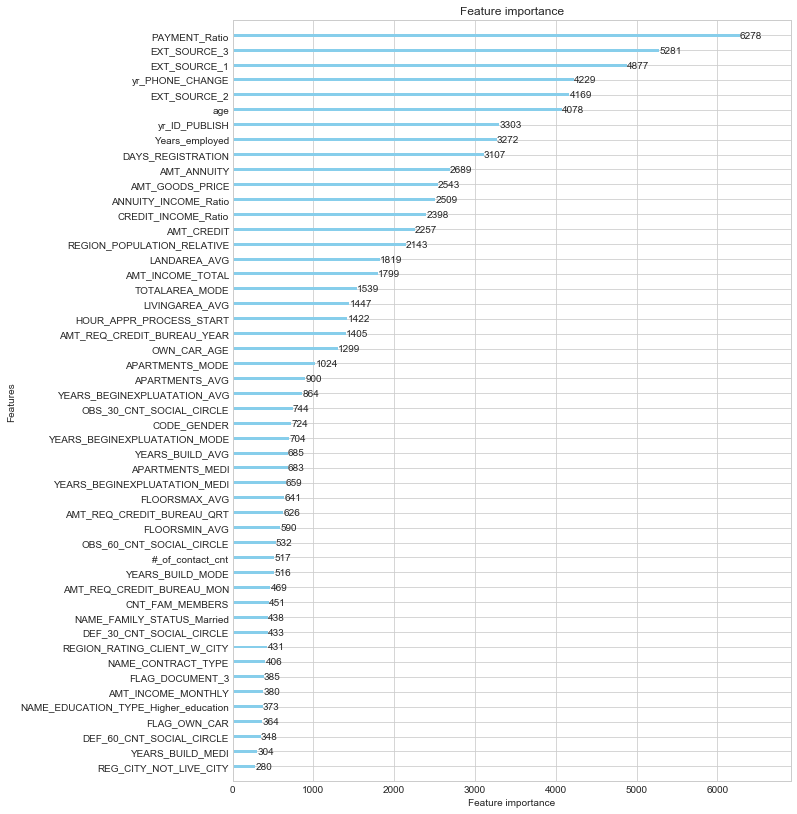

In [21]:
lgb.plot_importance(model, figsize=(10, 14), color='skyblue', max_num_features=50);

# Part 2 -Bureau data

#### example SK_ID_CURR = 215354 had 11 credit transactions before the current application.

In [33]:
bureau[bureau['SK_ID_CURR'] ==  215354]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0000,-153.0000,nan,0,91323.0000,0.0000,nan,0.0000,Consumer credit,-131,nan
1,215354,5714463,Active,currency 1,-208,0,1075.0000,nan,nan,0,225000.0000,171342.0000,nan,0.0000,Credit card,-20,nan
2,215354,5714464,Active,currency 1,-203,0,528.0000,nan,nan,0,464323.5000,nan,nan,0.0000,Consumer credit,-16,nan
3,215354,5714465,Active,currency 1,-203,0,nan,nan,nan,0,90000.0000,nan,nan,0.0000,Credit card,-16,nan
4,215354,5714466,Active,currency 1,-629,0,1197.0000,nan,77674.5000,0,2700000.0000,nan,nan,0.0000,Consumer credit,-21,nan
5,215354,5714467,Active,currency 1,-273,0,27460.0000,nan,0.0000,0,180000.0000,71017.3800,108982.6200,0.0000,Credit card,-31,nan
6,215354,5714468,Active,currency 1,-43,0,79.0000,nan,0.0000,0,42103.8000,42103.8000,0.0000,0.0000,Consumer credit,-22,nan
225157,215354,5714458,Closed,currency 1,-1872,0,-776.0000,-1203.0000,nan,0,494550.0000,0.0000,0.0000,0.0000,Consumer credit,-696,nan
225158,215354,5714459,Closed,currency 1,-1734,0,-638.0000,-1336.0000,nan,0,1084032.0000,0.0000,nan,0.0000,Car loan,-1336,nan
225159,215354,5714460,Closed,currency 1,-1333,0,-1089.0000,-987.0000,nan,0,102150.0000,nan,nan,0.0000,Consumer credit,-984,nan


In [31]:
bureau[bureau['SK_ID_BUREAU'] == 5715448]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
768,380361,5715448,Active,currency 1,-820,0,31069.0000,nan,nan,0,67500.0000,0.0000,67500.0000,0.0000,Credit card,-183,0.0000


In [32]:
bureau[bureau['SK_ID_CURR'] == 380361]

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
768,380361,5715448,Active,currency 1,-820,0,31069.0000,nan,nan,0,67500.0000,0.0000,67500.0000,0.0000,Credit card,-183,0.0000
769,380361,5715449,Active,currency 1,-357,0,1119.0000,nan,nan,0,45000.0000,0.0000,45000.0000,0.0000,Credit card,-130,2691.0000
770,380361,5715451,Closed,currency 1,-917,0,-187.0000,-759.0000,nan,0,74439.0000,0.0000,0.0000,0.0000,Consumer credit,-748,0.0000
771,380361,5715452,Closed,currency 1,-993,0,31039.0000,-831.0000,nan,0,315000.0000,0.0000,0.0000,0.0000,Credit card,-818,0.0000
772,380361,5715453,Closed,currency 1,-1146,0,681.0000,-780.0000,nan,0,2025000.0000,0.0000,0.0000,0.0000,Consumer credit,-769,0.0000
773,380361,5715454,Closed,currency 1,-1622,0,-1074.0000,-1073.0000,nan,0,540000.0000,0.0000,0.0000,0.0000,Consumer credit,-1006,0.0000
774,380361,5715455,Closed,currency 1,-2631,0,-804.0000,-1096.0000,nan,0,2205000.0000,0.0000,0.0000,0.0000,Car loan,-944,nan
775,380361,5715456,Closed,currency 1,-1449,0,-1084.0000,-1267.0000,nan,0,60480.0000,0.0000,0.0000,0.0000,Consumer credit,-1259,nan
776,380361,5715457,Active,currency 1,-222,0,874.0000,nan,nan,0,202500.0000,31594.5000,0.0000,0.0000,Credit card,-18,0.0000
777,380361,5715458,Closed,currency 1,-749,0,-111.0000,-110.0000,nan,0,1267843.5000,0.0000,nan,0.0000,Consumer credit,-110,0.0000


In [35]:
bureau_bal['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

In [44]:
bureau_bal1['status_cnt']=bureau_bal.groupby(['SK_ID_BUREAU','STATUS']).transform('count')

In [ ]:
bureau_bal_agg= pd.DataFrame({'SK_ID_BUREAU': bureau['SK_ID_BUREAU'].unique()})
bureau_bal_agg['DPD_count'] = bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].transform('count')

In [46]:
bureau_bal1[bureau_bal1['status_cnt'] == 5715448]
bureau[bureau['SK_ID_CURR'] == 380361]

,MONTHS_BALANCE,status_cnt


In [43]:
bureau_bal[bureau_bal['SK_ID_BUREAU'] == 5715448]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


In [29]:
bureau_bal[bureau_bal['SK_ID_BUREAU'] == 5715448]

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0


### Feature engineering

+ total count of loans in bureau
+ min, max, sum, average, var of DAYS_CREDIT/DAYS_CREDIT_UPDATE/AMT_CREDIT_SUM/
+ AMT_CREDIT_debit_ratio

In [49]:
## create new feature
# total count of loans in bureau
bureau_agg = pd.DataFrame({'SK_ID_CURR': bureau['SK_ID_CURR'].unique()})
bureau_agg['loans_count'] = bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].transform('count')

In [ ]:
bureau_agg['Active_count']=bureau[bureau['CREDIT_ACTIVE'] == 'Active'].count('SK_ID_BUREAU')

In [80]:
bureau_agg[bureau_agg['SK_ID_CURR'] == 380361]

,SK_ID_CURR,Active_count
198053,380361,nan


In [60]:
bureau_agg= bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby(['SK_ID_CURR']).size().reset_index(name='Active_count') 

In [57]:
bureau_agg['Active_count']=[bureau[bureau["CREDIT_ACTIVE"]=='Active']].count()['']
bureau_agg['Active_count']= bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby(['SK_ID_CURR']).size().reset_index() 

TypeError: count() takes exactly one argument (0 given)

In [ ]:
bureau_agg

In [ ]:
df1 = df1.merge(bureau_agg, on=['SK_ID_CURR'], how='left')

In [ ]:
# Group by the client id, calculate aggregation statistics
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['mean', 'max', 'min', 'sum','var']).reset_index()
bureau_agg.head()

In [ ]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':
        
        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [ ]:
# Assign the list of columns names as the dataframe column names
bureau_agg.columns = columns
bureau_agg.head()

In [28]:
bureau_AGG_list = []
for agg in ['mean', 'min', 'max','sum','var']:
    for select in ['DAYS_CREDIT', 'AMT_CREDIT_SUM', 'DAYS_CREDIT_UPDATE','CREDIT_DAY_OVERDUE','AMT_ANNUITY','AMT_CREDIT_SUM_DEBT']:
        bureau_AGG_list.append((select, agg))
bureau_AGG_list = [(['SK_ID_CURR'], bureau_AGG_list)]

In [29]:
groupby_agg_names = []
for groupby_cols, specs in tqdm(bureau_AGG_list ):
    group_object = bureau.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_agg_name = '{}_{}_{}'.format('bureau_AGG_',select, agg)
        df1 = df1.merge(group_object[select]
                                 .agg(agg)
                                 .reset_index()
                                 .rename(index=str, columns={select: groupby_agg_name})
                                 [groupby_cols +[groupby_agg_name]],
                                 on=groupby_cols,
                                 how='left')
        groupby_agg_names.append(groupby_agg_name)

A Jupyter Widget

A Jupyter Widget

In [30]:
## after merge 2nd dataset
df1.shape

(356251, 231)

In [31]:
df1.head(2)

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLOORSMAX_AVG,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,HOUR_APPR_PROCESS_START,LANDAREA_AVG,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAREA_AVG,NAME_CONTRACT_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,Years_employed,age,AMT_INCOME_MONTHLY,CREDIT_INCOME_Ratio,ANNUITY_INCOME_Ratio,PAYMENT_Ratio,# of contact cnt,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: typ

In [32]:
df1['AMT_CREDIT_debit_ratio']=df1['bureau_AGG__AMT_CREDIT_SUM_DEBT_sum']/df1['bureau_AGG__AMT_CREDIT_SUM_sum'] 

In [33]:
# For check purpose, make sure after merge no duplicates  
df1[df1['SK_ID_CURR'] == 215354]

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLOORSMAX_AVG,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,HOUR_APPR_PROCESS_START,LANDAREA_AVG,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAREA_AVG,NAME_CONTRACT_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,Years_employed,age,AMT_INCOME_MONTHLY,CREDIT_INCOME_Ratio,ANNUITY_INCOME_Ratio,PAYMENT_Ratio,# of contact cnt,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: typ

# Part 3 - Previous application

In [34]:
previous_app[previous_app['SK_ID_CURR'] == 215354]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
139772,1130982,215354,Consumer loans,25817.8950,150043.5000,140827.5000,15007.5000,150043.5000,FRIDAY,11,Y,1,0.1049,nan,nan,XAP,Approved,-346,Cash through the bank,XAP,NaN,Repeater,Jewelry,POS,XNA,Stone,50,Industry,6.0000,middle,POS other with interest,365243.0000,-314.0000,-164.0000,-194.0000,-190.0000,0.0000
528263,1927804,215354,Consumer loans,12750.7500,337500.0000,337500.0000,0.0000,337500.0000,TUESDAY,18,Y,1,0.0000,nan,nan,XAP,Approved,-265,Cash through the bank,XAP,NaN,Repeater,Medicine,POS,XNA,Stone,25,Industry,36.0000,low_normal,POS other with interest,365243.0000,-233.0000,817.0000,365243.0000,365243.0000,0.0000
701139,2829838,215354,Cash loans,51081.7500,1125000.0000,1125000.0000,nan,1125000.0000,SATURDAY,11,Y,1,nan,nan,nan,XNA,Approved,-919,Cash through the bank,XAP,Unaccompanied,Refreshed,XNA,Cash,x-sell,AP+ (Cash loan),39,XNA,48.0000,middle,Cash X-Sell: middle,365243.0000,-887.0000,523.0000,365243.0000,365243.0000,0.0000
1318169,1362380,215354,Consumer loans,5384.2950,35955.0000,34492.5000,3600.0000,35955.0000,FRIDAY,9,Y,1,0.1029,nan,nan,XAP,Approved,-2579,Cash through the bank,XAP,Unaccompanied,New,Other,POS,XNA,Country-wide,613,Consumer electronics,8.0000,high,POS household with interest,365243.0000,-2548.0000,-2338.0000,-2338.0000,-2332.0000,1.0000
1334969,2340808,215354,Revolving loans,22500.0000,0.0000,450000.0000,nan,nan,SATURDAY,11,Y,1,nan,nan,nan,XAP,Approved,-919,XNA,XAP,NaN,Refreshed,XNA,Cards,x-sell,AP+ (Cash loan),39,XNA,0.0000,XNA,Card X-Sell,-887.0000,-845.0000,365243.0000,365243.0000,365243.0000,0.0000


In [35]:
## numerical variables
PREVIOUS_APP_AGG_list = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_ANNUITY',
                   'AMT_APPLICATION',
                   'AMT_CREDIT',
                   'AMT_DOWN_PAYMENT',
                   'AMT_GOODS_PRICE',
                   'CNT_PAYMENT',
                   'DAYS_DECISION',
                   'HOUR_APPR_PROCESS_START',
                   'RATE_DOWN_PAYMENT'
                   ]:
           PREVIOUS_APP_AGG_list.append((select, agg))
PREVIOUS_APP_AGG_list = [(['SK_ID_CURR'], PREVIOUS_APP_AGG_list)]

In [36]:
groupby_agg_names = []
for groupby_cols, specs in tqdm(PREVIOUS_APP_AGG_list):
    group_object = previous_app.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_agg_name = '{}_{}_{}'.format('PRE_APP_',select, agg)
        df1 = df1.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_agg_name})
                              [groupby_cols + [groupby_agg_name]],
                              on=groupby_cols,
                              how='left')
        groupby_agg_names.append(groupby_agg_name)

A Jupyter Widget

A Jupyter Widget

In [37]:
df1[df1['SK_ID_CURR'] == 215354]

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLOORSMAX_AVG,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,HOUR_APPR_PROCESS_START,LANDAREA_AVG,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAREA_AVG,NAME_CONTRACT_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,Years_employed,age,AMT_INCOME_MONTHLY,CREDIT_INCOME_Ratio,ANNUITY_INCOME_Ratio,PAYMENT_Ratio,# of contact cnt,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: typ

In [38]:
## after merge 3nd dataset
df1.shape

(356251, 277)

# Part 4 - credit card balance dataset (monthly)

In [39]:
credit_card_bal[credit_card_bal['SK_ID_CURR'] == 215354].sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
1563720,2340808,215354,-30,0.0000,450000,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000,nan,Active,0,0
426146,2340808,215354,-29,1345.5000,450000,135000.0000,135000.0000,0.0000,0.0000,nan,137025.0000,137025.0000,0.0000,0.0000,0.0000,1.0000,1,0.0000,0.0000,nan,Active,0,0
2606963,2340808,215354,-28,45708.2550,450000,45000.0000,45000.0000,0.0000,0.0000,nan,2025.0000,679.5000,44320.5000,44362.7550,44362.7550,1.0000,1,0.0000,0.0000,nan,Active,0,0
1786354,2340808,215354,-27,91814.7600,450000,76500.0000,101104.7400,0.0000,24604.7400,1345.5000,65029.5000,62779.5000,89601.5700,90469.2600,90469.2600,2.0000,10,0.0000,8.0000,1.0000,Active,0,0
2102982,2340808,215354,-26,176942.1150,450000,132750.0000,187372.8900,0.0000,54622.8900,2250.0000,112500.0000,112500.0000,164474.4600,168869.1150,168869.1150,6.0000,21,0.0000,15.0000,2.0000,Active,0,0
470554,2340808,215354,-25,191860.9200,450000,0.0000,13107.7800,0.0000,13107.7800,4824.2700,4950.0000,4950.0000,177582.2400,191860.9200,191860.9200,0.0000,3,0.0000,3.0000,3.0000,Active,0,0
384765,2340808,215354,-24,146877.6600,450000,135000.0000,150150.5100,0.0000,15150.5100,8932.2300,200308.5000,193421.4750,144740.8350,147896.7300,147896.7300,1.0000,9,0.0000,8.0000,4.0000,Active,0,0
3522419,2340808,215354,-23,157989.7800,450000,0.0000,6163.4250,0.0000,6163.4250,6887.0250,0.0000,0.0000,150904.2600,157989.7800,157989.7800,0.0000,3,0.0000,3.0000,5.0000,Active,0,0
263052,2340808,215354,-22,424505.0250,450000,279000.0000,279000.0000,0.0000,0.0000,7604.0100,30105.0000,10907.2350,415455.3000,424689.1200,424689.1200,4.0000,4,0.0000,0.0000,6.0000,Active,0,0
400185,2340808,215354,-21,440171.1900,450000,0.0000,0.0000,0.0000,0.0000,19197.7650,0.0000,0.0000,415455.3000,440171.1900,440171.1900,0.0000,0,0.0000,0.0000,7.0000,Active,0,0


In [40]:
## numerical variables
credit_card_bal_AGG_list = []
for agg in ['mean', 'min', 'max', 'sum', 'var']:
    for select in ['AMT_BALANCE',
    'AMT_CREDIT_LIMIT_ACTUAL',
    'AMT_DRAWINGS_ATM_CURRENT',
    'AMT_DRAWINGS_CURRENT',
    'AMT_DRAWINGS_OTHER_CURRENT',
    'AMT_DRAWINGS_POS_CURRENT',
    'AMT_INST_MIN_REGULARITY',
    'AMT_PAYMENT_CURRENT',
    'AMT_PAYMENT_TOTAL_CURRENT',
    'AMT_RECEIVABLE_PRINCIPAL',
    'AMT_RECIVABLE',
    'AMT_TOTAL_RECEIVABLE',
    'CNT_DRAWINGS_ATM_CURRENT',
    'CNT_DRAWINGS_CURRENT',
    'CNT_DRAWINGS_OTHER_CURRENT',
    'CNT_DRAWINGS_POS_CURRENT',
    'CNT_INSTALMENT_MATURE_CUM']:
          credit_card_bal_AGG_list.append((select, agg))
credit_card_bal_AGG_list = [(['SK_ID_CURR'], credit_card_bal_AGG_list)]

In [41]:
groupby_agg_names = []
for groupby_cols, specs in tqdm(credit_card_bal_AGG_list):
    group_object = credit_card_bal.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_agg_name = '{}_{}_{}'.format('credit_',select, agg)
        df1 = df1.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_agg_name})
                              [groupby_cols + [groupby_agg_name]],
                              on=groupby_cols,
                              how='left')
        groupby_agg_names.append(groupby_agg_name)

A Jupyter Widget

A Jupyter Widget

In [42]:
df1[df1['SK_ID_CURR'] == 215354]

,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_YEAR,APARTMENTS_AVG,APARTMENTS_MEDI,APARTMENTS_MODE,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_REGISTRATION,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_2,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_OWN_CAR,FLAG_OWN_REALTY,FLOORSMAX_AVG,FLOORSMAX_MODE,FLOORSMIN_AVG,FLOORSMIN_MEDI,HOUR_APPR_PROCESS_START,LANDAREA_AVG,LIVE_CITY_NOT_WORK_CITY,LIVE_REGION_NOT_WORK_REGION,LIVINGAREA_AVG,NAME_CONTRACT_TYPE,OBS_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,REGION_POPULATION_RELATIVE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,SK_ID_CURR,TARGET,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE,Years_employed,age,AMT_INCOME_MONTHLY,CREDIT_INCOME_Ratio,ANNUITY_INCOME_Ratio,PAYMENT_Ratio,# of contact cnt,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business Entity Type 1,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry: type 1,ORGANIZATION_TYPE_Industry: type 10,ORGANIZATION_TYPE_Industry: type 11,ORGANIZATION_TYPE_Industry: type 12,ORGANIZATION_TYPE_Industry: type 13,ORGANIZATION_TYPE_Industry: type 2,ORGANIZATION_TYPE_Industry: type 3,ORGANIZATION_TYPE_Industry: type 4,ORGANIZATION_TYPE_Industry: type 5,ORGANIZATION_TYPE_Industry: type 6,ORGANIZATION_TYPE_Industry: type 7,ORGANIZATION_TYPE_Industry: typ

In [43]:
## after merge 4th dataset
df1.shape

(356251, 362)

# Part 5 - POS_CASH_balance

In [44]:
POS_CASH_bal[POS_CASH_bal['SK_ID_CURR'] == 215354].sort_values('MONTHS_BALANCE')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
4802353,1362380,215354,-84,8.0000,8.0000,Active,0,0
4355326,1362380,215354,-83,8.0000,7.0000,Active,0,0
8923143,1362380,215354,-82,8.0000,6.0000,Active,0,0
4374636,1362380,215354,-81,8.0000,5.0000,Active,0,0
3710204,1362380,215354,-80,8.0000,4.0000,Active,0,0
1687741,1362380,215354,-79,8.0000,3.0000,Active,0,0
6039050,1362380,215354,-78,8.0000,2.0000,Active,0,0
2087412,1362380,215354,-77,8.0000,1.0000,Active,0,0
3978019,1362380,215354,-76,8.0000,0.0000,Completed,0,0
4226722,2829838,215354,-30,48.0000,48.0000,Active,0,0


In [45]:
POS_CASH_BAL_AGGR_list = []
for agg in ['mean', 'max','sum']:
    for select in [ 'SK_DPD', 'SK_DPD_DEF']:
        POS_CASH_BAL_AGGR_list.append((select, agg))
POS_CASH_BAL_AGGR_list = [(['SK_ID_CURR'], POS_CASH_BAL_AGGR_list)]

In [46]:
groupby_agg_names = []
for groupby_cols, specs in tqdm(POS_CASH_BAL_AGGR_list):
    group_object = POS_CASH_bal.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_agg_name = '{}_{}_{}'.format('POS_CASH_',select, agg)
        df1 = df1.merge(group_object[select]
                                 .agg(agg)
                                 .reset_index()
                                 .rename(index=str, columns={select: groupby_agg_name})
                                 [groupby_cols + [groupby_agg_name]],
                                 on=groupby_cols,
                                 how='left')
        groupby_agg_names.append(groupby_agg_name)

A Jupyter Widget

A Jupyter Widget

In [47]:
## after merge 5th dataset
df1.shape

(356251, 368)

# Part 6- instalallement 

In [48]:
instal_pay[instal_pay['SK_ID_CURR'] == 215354]

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
3815405,2340808,215354,0.0000,29,-479.0000,-479.0000,203.9400,203.9400
3875768,2829838,215354,3.0000,22,-257.0000,-263.0000,11729.2500,11729.2500
3887672,2340808,215354,0.0000,21,-607.0000,-607.0000,293056.4700,293056.4700
3895920,1130982,215354,2.0000,5,-194.0000,-209.0000,50932.2600,50932.2600
3929188,1130982,215354,1.0000,3,-254.0000,-262.0000,25817.8950,25817.8950
3972222,1927804,215354,1.0000,2,-203.0000,-215.0000,12750.7500,12750.7500
3983768,2340808,215354,0.0000,40,-297.0000,-291.0000,16252.9200,2077.9200
4041955,2829838,215354,3.0000,12,-557.0000,-558.0000,11729.2500,11729.2500
4043223,2829838,215354,1.0000,4,-797.0000,-797.0000,51081.7500,51081.7500
4048101,2340808,215354,0.0000,31,-450.0000,-450.0000,1184.0400,1184.0400


In [49]:
instal_pay_AGGR_list = []
for agg in ['max', 'mean', 'sum']:
    for select in ['AMT_INSTALMENT', 'AMT_PAYMENT']:
        instal_pay_AGGR_list.append((select, agg))
instal_pay_AGGR_list = [(['SK_ID_CURR'], instal_pay_AGGR_list)]

In [50]:
groupby_agg_names = []
for groupby_cols, specs in tqdm(instal_pay_AGGR_list):
    group_object = instal_pay.groupby(groupby_cols)
    for select, agg in tqdm(specs):
        groupby_agg_name = '{}_{}_{}'.format('instal_',select, agg)
        df1 = df1.merge(group_object[select]
                              .agg(agg)
                              .reset_index()
                              .rename(index=str,
                                      columns={select: groupby_agg_name})
                              [groupby_cols + [groupby_agg_name]],
                              on=groupby_cols,
                              how='left')
        groupby_agg_names.append(groupby_agg_name)

A Jupyter Widget

A Jupyter Widget

In [ ]:
# ['PAYMENT_Ratio'] = ['AMT_PAYMENT'] / ['AMT_INSTALMENT']
#  ['PAYMENT_DIFF'] = ['AMT_INSTALMENT'] -['AMT_PAYMENT']

In [51]:
# df1[df1['SK_ID_CURR'] == 215354]

In [52]:
## after merge 6 dataset
df1.shape

(356251, 374)

## Model 2-include all tables 

In [53]:
df2=df1.copy()

In [54]:
df_train2 = df2[df2['TARGET']!=2]
df_test2 = df2[df2['TARGET']==2]
df_test2 = df2.drop(['TARGET'], axis=1)
y2 = df_train2['TARGET']
X2 = df_train2.drop(['TARGET','SK_ID_CURR'], axis=1)
print('Training Features shape: ', df_train2.shape)
print('Testing Features shape: ', df_test2.shape)
print('X2: ', X2.shape)
print('y2: ', y2.shape)

Training Features shape:  (307507, 374)
Testing Features shape:  (356251, 373)
X2:  (307507, 372)
y2:  (307507,)


In [55]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(X2, y2, test_size=0.20, random_state=42)
lgb_train2 = lgb.Dataset(data=X_train2, label=y_train2)
lgb_eval2 = lgb.Dataset(data=X_valid2, label=y_valid2)

In [56]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 48, 
          'num_iteration': 5000, 
          'verbose': 0 ,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth':7, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1}
model = lgb.train(params, lgb_train2, valid_sets=lgb_eval2, early_stopping_rounds=150, verbose_eval=200)

Training until validation scores don't improve for 150 rounds.
[200]	valid_0's auc: 0.756987
[400]	valid_0's auc: 0.768629
[600]	valid_0's auc: 0.773944
[800]	valid_0's auc: 0.776845
[1000]	valid_0's auc: 0.778509
[1200]	valid_0's auc: 0.779595
[1400]	valid_0's auc: 0.780437
[1600]	valid_0's auc: 0.780737
[1800]	valid_0's auc: 0.781023
[2000]	valid_0's auc: 0.781225
[2200]	valid_0's auc: 0.781342
[2400]	valid_0's auc: 0.781439
[2600]	valid_0's auc: 0.781496
Early stopping, best iteration is:
[2646]	valid_0's auc: 0.781583


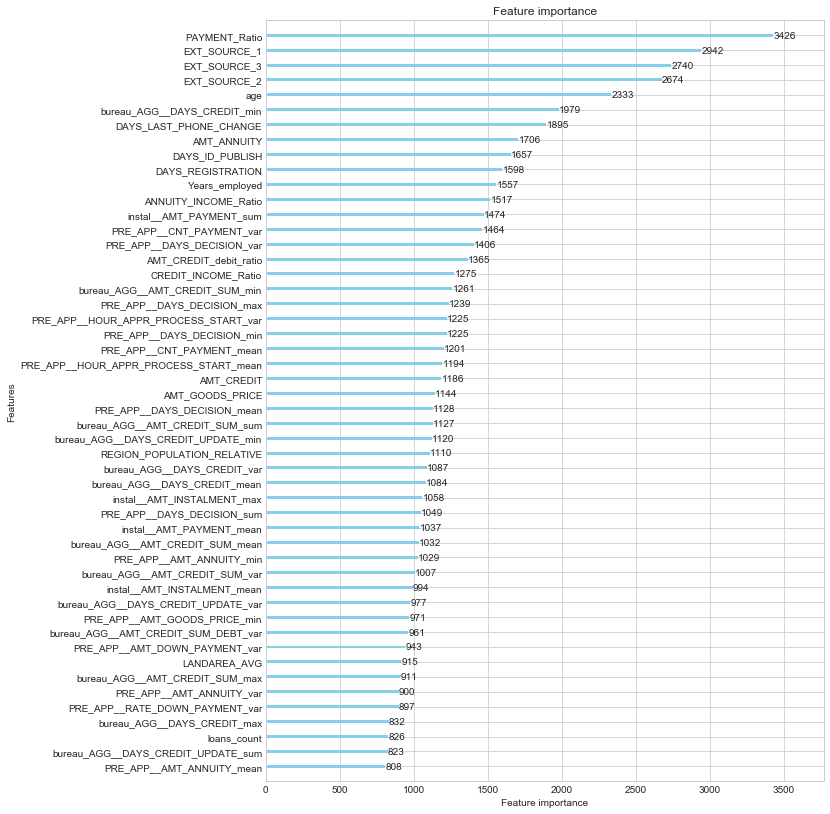

In [57]:
lgb.plot_importance(model, figsize=(10, 14), color='skyblue', max_num_features=50);

### still work on the following part

### Model 3-XGB 

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.grid_search import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [60]:
df3=df2.copy()

In [61]:
df_train3 = df3[df3['TARGET']!=2]
df_test3 = df3[df3['TARGET']==2]
df_test3 = df3.drop(['TARGET'], axis=1)
y3 = df_train3['TARGET']
X3 = df_train3.drop(['TARGET','SK_ID_CURR'], axis=1)
print('Training Features shape: ', df_train3.shape)
print('Testing Features shape: ', df_test3.shape)
print('X3: ', X3.shape)
print('y3: ', y3.shape)

Training Features shape:  (307507, 374)
Testing Features shape:  (356251, 373)
X3:  (307507, 372)
y3:  (307507,)


In [58]:
def create_X_ml_pipeline(cat_attrs, num_attrs):
    """
    Create ml pipeline for the features by first processing numerical and then categorical attribute.
    Afterwards, it combines those to create final transformed X attribute.
    
    arguement:
    cat_attrs -- list of categorical attribute
    num_attrs -- list of numerical attribute
    
    return: a full X ML pipeline, which can be used for train and test data
    """
    
    num_pipeline = Pipeline([
       ('selector', DataFrameSelector(num_attrs)),
       ('imputer', preprocessing.Imputer(strategy="median")),
       ('std_scaler', preprocessing.StandardScaler()),
    ])

    cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(cat_attrs)),
        ('cat_enc', CategoricalEncoder(encoding="onehot-dense")),
    ])
    
    full_pipeline = FeatureUnion(transformer_list=[
        ('num_pipeline', num_pipeline),
        ('cat_pipeline', cat_pipeline),
    ])
    
    return full_pipeline

In [75]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y3, stratify=y, test_size=0.3, random_state=42)

In [76]:
y_train3.value_counts()

0    197877
1     17377
Name: TARGET, dtype: int64

In [ ]:
xgb1 = XGBClassifier(learning_rate =0.01, 
                     n_estimators=1000,max_depth=5, 
                     objective='binary:logistic', 
                     gamma=0.1, 
                     subsample=0.5, scale_pos_weight=0.8 )
xgb1.fit(X_train3, y_train3)
auc = roc_auc_score(y_train3, xgb1.predict(X_train3))
print("Performance of training : ", auc)

Reference :
1. https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/
2. https://xgboost.readthedocs.io/en/latest/parameter.html
3. https://www.analyticsvidhya.com/blog/2017/03/imbalanced-classification-problem/

In [ ]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=12, ratio = 1.0)
# x_train_res, y_train_res = sm.fit_sample(X_train3, y_train3)